# Robust regression of a trend with Julia and JuMP

example based on radar data

In [2]:
VERSION

v"0.6.3"

In [43]:
using PyPlot

Solvers

In [171]:
using JuMP
using ECOS # for Second-order cone constraints http://www.juliaopt.org/JuMP.jl/0.18/refmodel.html#second-order-cone-constraints
using Ipopt # quadratic objective

In [3]:
data = readcsv("radar_data.csv");

In [76]:
n = size(data)[1]

300

In [42]:
x = data[:,1]
y = data[:,2];

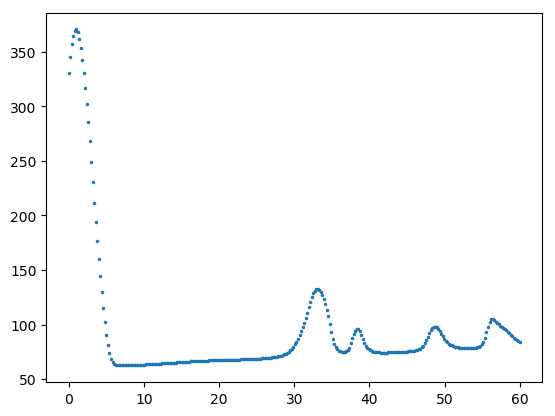

In [44]:
plot(x,y, ".", ms=3);

## Least square regression

model:

$$\hat{y} = a.x+b$$

$$\theta = (b,a)^T$$

$$ \min_\theta \lVert X\theta - y \lVert_2 $$

In [70]:
X = hcat(ones(x), x);

In [72]:
b_ls, a_ls = X \ y
a_ls, b_ls

(-1.094307150714308, 127.525735280701)

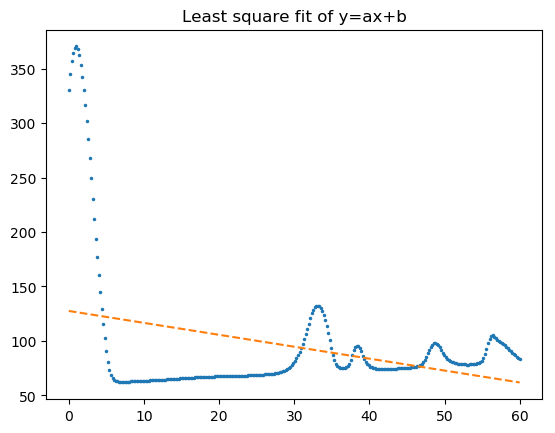

PyObject Text(0.5,1,'Least square fit of y=ax+b')

In [87]:
plot(x,y, ".", ms=3)
plot(x,a_ls*x+b_ls, "--");
title("Least square fit of y=ax+b")

In [167]:
function solve_silent(m)
    TT = STDOUT # save original STDOUT stream
    redirect_stdout()
    status = solve(m)
    redirect_stdout(TT) # restore STDOUT
    status
end

solve_silent (generic function with 1 method)

In [60]:
m = Model(solver = ECOSSolver())

@variable(m, a )
@variable(m, b )
@variable(m, j )

j

In [61]:
res = a*x .- y +b

300-element Array{JuMP.GenericAffExpr{Float64,JuMP.Variable},1}:
 b - 330.0000004216058                        
 0.20066889632107024 a + b - 345.0355187060472
 0.4013377926421405 a + b - 356.5855778903129 
 0.6020066889632107 a + b - 364.6501778504438 
 0.802675585284281 a + b - 369.2293185525956  
 1.0033444816053512 a + b - 370.32299998680895
 1.2040133779264215 a + b - 367.9312221514166 
 1.4046822742474916 a + b - 362.0539850507466 
 1.605351170568562 a + b - 352.9823694277756  
 1.8060200668896322 a + b - 342.29916802426004
 2.0066889632107023 a + b - 330.2426578892699 
 2.2073578595317724 a + b - 316.8128392535288 
 2.408026755852843 a + b - 302.00971281527757 
 ⋮                                            
 57.79264214046823 a + b - 97.06107979605143  
 57.9933110367893 a + b - 95.90959196763387   
 58.19397993311037 a + b - 94.67049759008214  
 58.39464882943144 a + b - 93.36561430234113  
 58.59531772575251 a + b - 92.01975148880365  
 58.79598662207358 a + b - 90.660262577096

In [69]:
@constraint(m, norm(res) <= j);

In [63]:
@objective(m, Min, j)

j

In [67]:
status = solve(m)


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +2e+03  3e-01  1e-06  1e+00  1e+03    ---    ---    1  1  - |  -  - 
 1  +6.778e+02  +7.068e+02  +3e+02  2e-02  1e-07  3e+01  2e+02  0.8752  3e-02   2  3  3 |  0  0
 2  +9.997e+02  +1.001e+03  +4e+00  2e-04  1e-09  9e-01  2e+00  0.9890  3e-03   3  4  4 |  0  0
 3  +1.004e+03  +1.004e+03  +4e-02  2e-06  1e-11  1e-02  3e-02  0.9890  1e-04   3  2  2 |  0  0
 4  +1.004e+03  +1.004e+03  +5e-04  2e-08  1e-13  1e-04  3e-04  0.9890  1e-04   3  2  2 |  0  0
 5  +1.004e+03  +1.004e+03  +5e-06  3e-10  1e-15  1e-06  3e-06  0.9890  1e-04   3  1  1 |  0  0

OPTIMAL (within feastol=2.6e-10, reltol=5.4e-09, abstol=5.4e-06).
Runtime: 0.000677 seconds.



:Optimal

In [68]:
getvalue(a), getvalue(b)

(-1.094307126964816, 127.52573439383087)

## Least absolute value

$$ \min_\theta \lVert X\theta - y \lVert_1 = \sum_k \lvert y_k - ax_k - b\rvert $$

In [79]:
using Clp

INFO: Recompiling stale cache file /home/pierre/.julia/lib/v0.6/Clp.ji for module Clp.


In [82]:
m = Model(solver = ClpSolver())

@variable(m, a )
@variable(m, b )
@variable(m, t[1:n] )
res = a*x .- y +b
@constraint(m, res .<= t)
@constraint(m, res .>= -t)
@objective(m, Min, sum(t));

In [83]:
status = solve(m)

:Optimal

In [88]:
a_lav, b_lav = getvalue(a), getvalue(b)

(0.43761021724890264, 59.09093873002771)

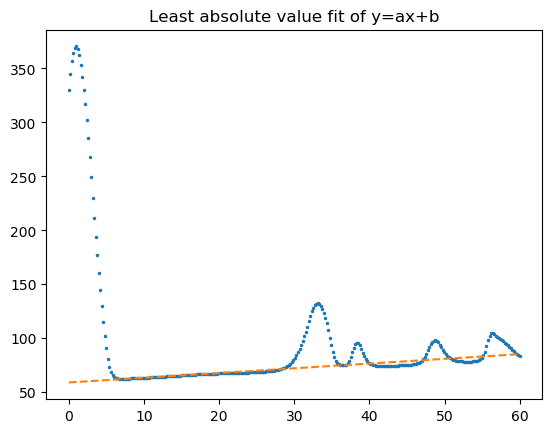

PyObject Text(0.5,1,'Least absolute value fit of y=ax+b')

In [89]:
plot(x,y, ".", ms=3)
plot(x,a_lav*x+b_lav, "--");
title("Least absolute value fit of y=ax+b")

## Hubert

$$ \min_\theta  \sum_k h( y_k - ax_k - b) $$

with Huber penalty function $h$

$$h(r) = \begin{cases}
    r^2&                  \lvert r \rvert \leq 1 \\
    2\lvert r \rvert - 1& \lvert r \rvert    > 1
\end{cases}
$$

Boyd Example 6.2

http://cvxopt.org/examples/book/huber.html

In [166]:
m = Model(solver = IpoptSolver())

@variable(m, a)
@variable(m, b)
@variable(m, 0 <= u[1:n] <= 1)
@variable(m, v[1:n] >= 0)

res = (a*x .- y +b)/10 # scaling of residuals, to set the transition between quadratic and lin penalty

@constraint(m, res .<=  u .+ v)
@constraint(m, res .>= -u .- v)
@objective(m, Min, 1/2*u'*u + sum(v));

In [170]:
tic()
status = solve_silent(m)
toc()
status

elapsed time: 0.054524383 seconds


:Optimal

In [125]:
a_hub, b_hub = getvalue(a), getvalue(b)

(0.40718494326478827, 61.7427928079724)

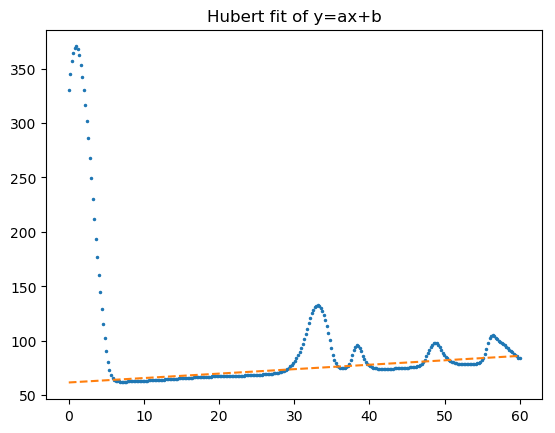

PyObject Text(0.5,1,'Hubert fit of y=ax+b')

In [126]:
plot(x,y, ".", ms=3)
plot(x,a_hub*x+b_hub, "--");
title("Hubert fit of y=ax+b")

In [148]:
m = Model(solver = ECOSSolver(log=1))

@variable(m, a)
@variable(m, b)
@variable(m, u_norm)
@variable(m, 0 <= u[1:n] <= 1)
@variable(m, v[1:n] >= 0)

res = (a*x .- y +b)/10 # scaling of residuals, to set the transition between quadratic and lin penalty

@constraint(m, res .<=  u .+ v)
@constraint(m, res .>= -u .- v)
@constraint(m, norm(u) <= u_norm) 
@objective(m, Min, 1/2*u_norm + sum(v));

In [149]:
tic()
status = solve(m)
toc()

elapsed time: 0.01569805 seconds

ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -5.920e+01  -4.342e+02  +6e+04  8e-01  6e-01  1e+00  4e+01    ---    ---    1  2  - |  -  - 
 1  +3.864e+02  +2.755e+02  +3e+04  3e-01  1e-01  3e+00  2e+01  0.5819  2e-01   2  2  1 |  0  0
 2  +4.001e+02  +3.581e+02  +1e+04  1e-01  4e-02  1e+00  1e+01  0.5558  8e-02   2  1  1 |  0  0
 3  +4.312e+02  +4.118e+02  +8e+03  4e-02  2e-02  7e-01  5e+00  0.5289  1e-01   2  1  1 |  0  0
 4  +4.683e+02  +4.596e+02  +4e+03  2e-02  6e-03  3e-01  3e+00  0.5446  9e-02   2  1  2 |  0  0
 5  +5.059e+02  +5.026e+02  +2e+03  6e-03  2e-03  1e-01  1e+00  0.6239  7e-02   2  2  2 |  0  0
 6  +5.324e+02  +5.319e+02  +3e+02  9e-04  3e-04  2e-02  2e-01  0.8553  3e-02   2  2  2 |  0  0
 7  +5.368e+02  +5.366e+02  +1e+02  4e-04  1e-04  7e-03  8e-02  0.6192  8e-02   2  2  2 |  0  0
 8  +5.391e+0

0.01569805

In [159]:
?ClpSolver

search: ClpSolver



No documentation found.

**Summary:**

```
struct Clp.ClpMathProgSolverInterface.ClpSolver <: MathProgBase.SolverInterface.AbstractMathProgSolver
```

**Fields:**

```
options :: Any
```
